In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *
import os
import json

In [2]:
# Grab all data
data = untar_data(url='https://ds1.cs.calvin.edu/LkctzfaWUcJhWePeaqOv/subsets/yelp_photos_subset000.tgz')

# Get photo paths
path = data/'photos'

# Get JSON file
jsonFile = data/'photos.json'

In [3]:
# Transfer data in JSON file to a list (L class)
photos = []
with open(jsonFile) as f:
    for line in f:
        photos.append(json.loads(line))
photos = L(photos)

# Create dictionary with key-value pair 'photo_id':'label'
# Only add photo_ids as keys if the corresponding label is
#  'inside' or 'outside'
photoDict = {}
for photoJSON in photos:
    if photoJSON['label'] == 'inside' or photoJSON['label'] == 'outside':
        photoDict[photoJSON['photo_id']] = photoJSON['label']    

# Create new directory within 'photos' directory
in_out_path = path/'in-out'

# Create the directory if it doesn't currently exist
if not in_out_path.exists():
    in_out_path.mkdir()
    
# Look at each image in 'photos' directory and move images
#  with the desired labels to the 'in-out' subdirectory
for imgPath in get_image_files(path):
    imgName = imgPath.as_posix().split(path.as_posix())[1][1:]
    photoID = imgName[:-4]
    if photoID in photoDict:
        imgPath.rename(in_out_path/imgName)

In [4]:
# Given a photo name string ending with a extension, return the name 
#  without the extension.
# Assumes input string contains a "." and is a key in photoDict.
def label_in_out(x): return photoDict[x.split('.')[0]]

dls = ImageDataLoaders.from_name_func(
    in_out_path, get_image_files(in_out_path), valid_pct=0.2, seed=42,
    label_func=label_in_out, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [5]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.885000,0.394874,0.154079,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.444251,0.326219,0.135952,00:18


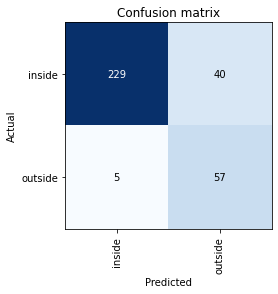

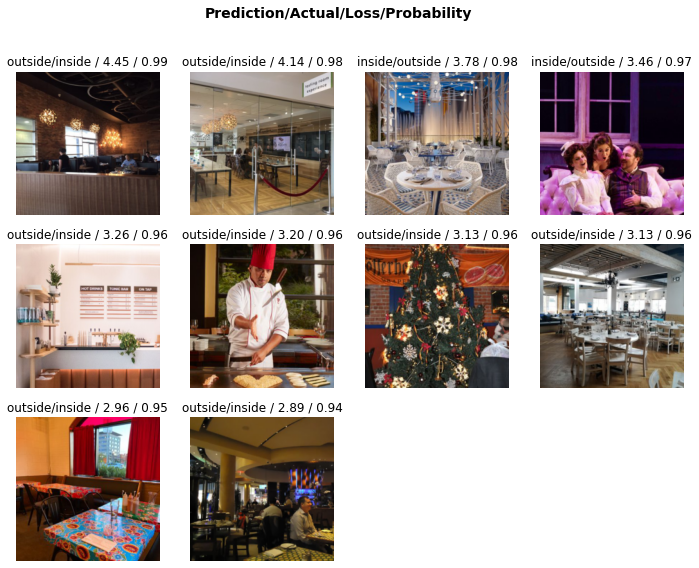

In [6]:
# Plot confusion matrix and top losses
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(10)

Below code to be implemented once I figure out where the learner goes...

In [13]:
# Export learner
learn.export(os.path.abspath('export.pkl'))  # should export to self.path/inOutClassifier.pkl

# export_path.ls() # check to see if .pkl file has been saved in self.path
learn_inf = load_learner('export.pkl')

(#4) [Path('IndoorOutdoorClassifier.ipynb'),Path('.ipynb_checkpoints'),Path('indoors1.jpeg'),Path('export.pkl')]

In [14]:
# Application interface
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [15]:
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [16]:
pred,pred_idx,probs = learn_inf.predict(img)